In [1]:
import numpy as np
import scipy.sparse as sparse
from scipy.sparse.linalg import lsmr
import jax
import jax.numpy as jnp
import jax.experimental as jexp
from jax.experimental import sparse as jexps
import networkx as nx
from math import exp
from functools import partial
import timeit
import random

In [ ]:
# def random_initial_parameters(e_range, b_range, f_range, n_nodes, n_ed):
#     """
#     Generate random initial parameters for a network with given ranges and dimensions.
#     Returns tuple of (ej_list, bij_list, fij_list) containing random values within specified ranges.
#     """
#     ej_list = (2 * np.random.random(n_nodes) - 1) * e_range
#     bij_list = (2 * np.random.random(n_edges) - 1) * b_range
#     fij_list = (2 * np.random.random(n_edges) - 1) * f_range
    
#     return (ej_list, bij_list, fij_list)

# def create_weight_matrix(graph_edges, Ej_list, Bij_list, Fij_list):
#     """
#     Update the weight matrix of a network based on given parameters and edge structure.
    
#     Parameters:
#     - graph_edges: List of edge pairs [(source, target), ...]
#     - ej_list: Array of node parameters
#     - bij_list: Array of edge bias parameters
#     - fij_list: Array of edge flow parameters
    
#     Returns:
#     - numpy array containing the weight matrix
#     """
#     n_nodes = len(ej_list)
#     W_mat = np.zeros((n_nodes, n_nodes))
    
#     # Populate the weight matrix using given formulas
#     for e, (i, j) in enumerate(graph_edges):
#         Bij = Bij_list[e]
#         Fij = Fij_list[e]
#         Ei = Ej_list[i]
#         Ej = Ej_list[j]
        
#         # Calculate weights
#         Wij = exp(-Bij + Ej + Fij/2)
#         Wji = exp(-Bij + Ei - Fij/2)
        
#         # Update matrix elements
#         W_mat[i, j] = Wij
#         W_mat[j, i] = Wji
    
#     # Adjust the diagonal elements of the weight matrix
#     for i in range(n_nodes):
#         W_mat[i, i] = -np.sum(W_mat[:, i])
    
#     return W_mat

# # Generate random parameters
# ej_list, bij_list, fij_list = random_initial_parameters(e_range, b_range, f_range, n_nodes, n_edges)


def create_W_mat(graph_edges, Wij_list, Wji_list):
    """
    Update the weight matrix of a network based on given parameters and edge structure.
    
    Parameters:
    - graph_edges: List of edge pairs [(source, target), ...]
    - ej_list: Array of node parameters
    - bij_list: Array of edge bias parameters
    - fij_list: Array of edge flow parameters
    
    Returns:
    - numpy array containing the weight matrix
    """
    n_nodes = len(ej_list)
    W_mat = np.zeros((n_nodes, n_nodes))
    
    # Populate the weight matrix using given formulas
    for e, (i, j) in enumerate(graph_edges):

        # Update matrix elements
        W_mat[i, j] = Wij_list[e]
        W_mat[j, i] = Wji_list[e]
    
    # Adjust the diagonal elements of the weight matrix
    for i in range(n_nodes):
        W_mat[i, i] = -np.sum(W_mat[:, i])
    
    return W_mat



@partial(jax.jit)#, static_argnums=(1,))
def get_steady_state_jax(A):
    x, *_ = jax.scipy.sparse.linalg.bicgstab(A.T @ A, A.T @ zero_array, tol=1e-4, maxiter=1000)
    return x


def get_Wijs(graph_edges, W_mat):
    Wij_list = []
    Wji_list = []
    
    for e, (i, j) in enumerate(graph_edges):
        Wij_list.append(W_mat[i, j])
        Wji_list.append(W_mat[j, i])

    return (np.array(Wij_list), np.array(Wji_list))

def apply_inputs(W_mat, graph_edges, indput_inds, inputs):
    """
    Update the weight matrix of a network based on given parameters and edge structure.

    Parameters:
    - wij_mat: original matrix
    - graph_edges: list of edges
    - indput_inds: input edge indices 
    - inputs: f_ij values 
    
    Returns:
    - numpy array containing the weight matrix
    """
    W_mat_ret = W_mat
    for m, input_ind in enumerate(input_inds):
        for sub_input_ind in input_ind:
            (i, j) = graph_edges[sub_input_ind]
            W_mat_ret[i, j] *= exp(inputs[m]/2)
            W_mat_ret[i,j] *= exp(-inputs[m]/2)

    for i in range(n_nodes):
        W_mat_ret[i, i] = -np.sum(W_mat_ret[:, i])
    
    return W_mat_ret

def augment_W_mat(W_mat):
    return jnp.vstack([W_mat, jnp.ones((1, n_nodes))])

def update_W_mat(graph_edges, W_mat, dW, eta):
    (Wij_list, Wji_list) = get_Wijs(graph_edges, W_mat)
    (dWij_list, dWji_list) = get_Wijs(graph_edges, dW)
    dwij_list = dWij_list * Wij_list
    dwji_list = dWji_list * Wji_list
    wij_list = np.log(Wij_list) + eta * dwij_list
    wji_list = np.log(Wji_list) + eta * dwji_list
    
    return create_W_mat(graph_edges, np.exp(wij_list), np.exp(wji_list))



done


In [4]:
# Initialize parameters
n_nodes = 150
e_range = 0
b_range = 0
f_range = 0

g = nx.complete_graph(n_nodes)

# Get edges (ensuring we have exactly n_edges)
graph_edges = list(g.edges())
n_edges = len(graph_edges)

Wij_list = np.ones(n_edges)
Wji_list = np.ones(n_edges)

# Calculate weight matrix
# W_mat = create_weight_matrix(graph_edges, ej_list, bij_list, fij_list)
W_mat = create_W_mat(graph_edges, Wij_list, Wji_list)
W_mat_augmented = augment_W_mat(W_mat)

# Convert to dense matrix for JAX compatibility
init = np.ones(n_nodes) / n_nodes
zero_array = jnp.zeros(n_nodes + 1).at[-1].set(1)

# Calculate steady state
ss = get_steady_state_jax(W_mat_augmented)

# Calculate Jacobian using JAX
jacobian_fn = jax.jacfwd(lambda A: get_steady_state_jax(A))
dW_mat = jacobian_fn(W_mat_augmented)



NameError: name 'ej_list' is not defined

In [162]:
n_inputs = 100
M = 2

shuffled_inds = list(range(n_edges))
random.shuffle(shuffled_inds)
input_inds = [shuffled_inds[m*M:(m+1)*M] for m in range(n_inputs)]

inputs = np.ones(n_inputs)

W_mat_input = apply_inputs(W_mat, graph_edges, input_inds, inputs)

In [134]:
len(graph_edges)


11175

In [418]:
import numpy as np
import scipy.sparse as sparse
from scipy.sparse.linalg import lsmr
import jax
import jax.numpy as jnp
import jax.experimental as jexp
from jax.experimental import sparse as jexps
import networkx as nx
from math import exp
from functools import partial
import timeit
import random
import copy


### class definitions
class WeightMatrix:
    def __init__(self, g, Wij_list, Wji_list):
        self.g = g
        self.graph_edges = list(g.edges())
        self.n_nodes = len(list(g.nodes()))
        self.n_edges = len(list(g.edges()))
        self.edge_array = self._get_edge_array()
        self.W_mat = self._create_W_mat(Wij_list, Wji_list)
        self.zero_array = jnp.zeros(len(list(g.nodes())) + 1).at[-1].set(1)
        
    
    def _create_W_mat(self, Wij_list, Wji_list):
        W_mat = np.zeros((self.n_nodes, self.n_nodes))
        W_mat[self.edge_array[:, 0], self.edge_array[:, 1]] = Wij_list  # Vectorized assignment
        W_mat[self.edge_array[:, 1], self.edge_array[:, 0]] = Wji_list  # Vectorized assignment
        
        for i in range(self.n_nodes):
            W_mat[i, i] = -np.sum(W_mat[:, i])
        
        return W_mat
    
    @staticmethod
    @partial(jax.jit)
    def get_steady_state(A, zero_array):
        # x, *_ = jax.scipy.sparse.linalg.bicgstab(A.T @ A, A.T @ zero_array, tol=1e-6, maxiter=5000)
        x, *_ = jax.scipy.sparse.linalg.cg(A.T @ A, A.T @ zero_array, tol=1e-4, maxiter=2000)
        return x
    
    def _get_edge_array(self):
        edge_index_list = []
        for i, (src, tgt) in enumerate(self.graph_edges):
            edge_index_list.append([src, tgt])
        return np.array(edge_index_list)
    
    def get_Wijs(self):
        Wij_list = self.W_mat[self.edge_array[:, 0], self.edge_array[:, 1]]  # Vectorized access
        Wji_list = self.W_mat[self.edge_array[:, 1], self.edge_array[:, 0]]  # Vectorized access
        return np.array(Wij_list), np.array(Wji_list)
    
    def current_steady_state(self):
        return self.get_steady_state(self.augmented_W_mat(), self.zero_array)
    
    def set_Wijs(self, Wij_list, Wji_list):

        self.W_mat.fill(0.0)
        self.W_mat[self.edge_array[:, 0], self.edge_array[:, 1]] = Wij_list  # Vectorized assignment
        self.W_mat[self.edge_array[:, 1], self.edge_array[:, 0]] = Wji_list  # Vectorized assignment
        
        for i in range(self.n_nodes):
            self.W_mat[i, i] = 0.0
            self.W_mat[i, i] = -np.sum(self.W_mat[:, i])

    
    def get_dWijs(self, dW):
        dWij_list = dW[self.edge_array[:, 0], self.edge_array[:, 1]]  # Vectorized access
        dWji_list = dW[self.edge_array[:, 1], self.edge_array[:, 0]]  # Vectorized access
        return dWij_list, dWji_list  # Already NumPy arrays

    
    def apply_inputs(self, input_inds, inputs):
        W_mat_ret = self.W_mat.copy()
        for m, input_ind in enumerate(input_inds):
            for sub_input_ind in input_ind:
                (i, j) = self.graph_edges[sub_input_ind]
                W_mat_ret[i, j] *= np.exp(inputs[m] / 2)
                W_mat_ret[j, i] *= np.exp(-inputs[m] / 2)
        
        for i in range(self.n_nodes):
            W_mat_ret[i, i] = 0.0
            W_mat_ret[i, i] = -np.sum(W_mat_ret[:, i])
        
        return W_mat_ret
    
    def compute_ss_on_inputs(self, input_inds, inputs):
        input_W_mat = self.apply_inputs(input_inds, inputs)
        return self.get_steady_state(self.augment_other(input_W_mat), self.zero_array)
    
    def augmented_W_mat(self):
        return jnp.vstack([self.W_mat, jnp.ones((1, self.n_nodes))])
    
    def augmented_input_W_mat(self, input_inds, inputs):
        return jnp.vstack([self.apply_inputs(input_inds, inputs), jnp.ones((1, self.n_nodes))])
    
    def augment_other(self, other_W_mat):
        return jnp.vstack([other_W_mat, jnp.ones((1, self.n_nodes))])
    
    def lower_output_energies(self, output_inds, fac):
        W_mat_ret = self.W_mat.copy()
        for output_ind in output_inds:
            W_mat_ret[:,output_ind] = W_mat_ret[:,output_ind] * exp(-fac)
        
        for i in range(self.n_nodes):
            W_mat_ret[i, i] = 0.0
            W_mat_ret[i, i] = -np.sum(W_mat_ret[:, i])
        
        self.W_mat = W_mat_ret

    def nudged_ss(self, nudge, output_inds):
        W_mat_nudged = self.W_mat.copy()
        for i, output_ind in enumerate(output_inds):
            W_mat_nudged[:,output_ind] = W_mat_nudged[:,output_ind] * exp(-nudge[i])

        for i in range(self.n_nodes):
            W_mat_nudged[i, i] = 0.0
            W_mat_nudged[i, i] = -np.sum(W_mat_nudged[:, i])

        return self.get_steady_state(self.augment_other(W_mat_nudged), self.zero_array)
        
    
    def update(self, dWijs, dWjis, eta):
        Wij_list, Wji_list = self.get_Wijs()
        
        # dwij_list = dWijs * Wij_list
        # dwji_list = dWjis * Wji_list
        
        # wij_list = np.log(np.clip(Wij_list, 1e-5, 1e3)) - eta * dwij_list
        # wji_list = np.log(np.clip(Wji_list, 1e-5, 1e3)) - eta * dwji_list

        # self.set_Wijs(np.exp(wij_list), np.exp(wji_list))

        # Compute the gradient update
        dwij_list = dWijs * dsoftplus_inverse(Wij_list)
        dwji_list = dWjis * dsoftplus_inverse(Wji_list)

        # Convert to unconstrained space using softplus inverse
        wij_list = softplus_inverse(Wij_list) - eta * dwij_list
        wji_list = softplus_inverse(Wji_list) - eta * dwji_list

        # Map back to the positive domain using softplus
        self.set_Wijs(softplus(wij_list), softplus(wji_list))

        # Compute the gradient update

        # # Convert to unconstrained space using softplus inverse
        # Wij_list = np.clip(Wij_list - eta * dWijs, 1e-3, 1e3)
        # Wji_list = np.clip(Wji_list - eta * dWjis, 1e-3, 1e3)

        # # Map back to the positive domain using softplus
        # self.set_Wijs(Wij_list, Wji_list)



class InputData:
    def __init__(self, n_classes, data_list, split_fac = 0.75):
        self.n_classes = n_classes
        self.labels = self._create_labels()
        self.training_data, self.testing_data = self._split_shuffle_data(data_list, split_fac)

    def _create_labels(self):
        labels = [np.zeros(self.n_classes) for n in range(self.n_classes)]
        for n in range(self.n_classes):
            labels[n][n] = 1.0
        return labels
    
    def _split_shuffle_data(self, data_list, split_fac):
        tr_data = []
        te_data = []
        for nc in range(self.n_classes):
            sub_data = data_list[nc]
            n_train = round(np.floor(split_fac * len(sub_data)))
            random.shuffle(sub_data)

            tr_data.append(iter(sub_data[:n_train]))
            te_data.append(iter(sub_data[n_train:]))
        return tr_data, te_data


### other functions
def compute_soft_maxed_output(ss, output_inds):
    vec = [ss[x] for x in output_inds]
    max_val = np.max(vec)  # Get max value
    exp_shifted = np.exp(vec - max_val)  # Subtract max before exponentiation
    return exp_shifted / np.sum(exp_shifted)  # Normalize

def get_input_inds(n_edges, input_dim, M):
    shuffled_inds = list(range(n_edges))
    random.shuffle(shuffled_inds)
    return [shuffled_inds[m*M:(m+1)*M] for m in range(input_dim)]

def get_output_inds(n_nodes, n_classes, rand_bool):
    output_inds = list(range(n_nodes))
    if rand_bool:
        random.shuffle(output_inds)
    return output_inds[:n_classes]

def random_initial_parameters(w_range, n_edges):
    """
    Generate random initial parameters for a network with given ranges and dimensions.
    Returns tuple of (ej_list, bij_list, fij_list) containing random values within specified ranges.
    """
    Wij_list = np.exp((2 * np.random.random(n_edges) - 1) * w_range)
    Wji_list = np.exp((2 * np.random.random(n_edges) - 1) * w_range)
    
    return Wij_list, Wji_list

def softplus_inverse(x):
    return jnp.log(jnp.exp(x) - 1)

def softplus(x):
    return jnp.log(jnp.exp(x) + 1)

def sigmoid(x):
    return 1 / (1 + jnp.exp(-x))

def dsoftplus_inverse(x):
    return 1 / (1 - jnp.expm1(-x))

        

In [460]:
### initialize network input-output 
M = 1
n_classes = 2

random.seed(11)

### Initialize weight_matrix
n_nodes = 6
n_edges = 40
output_inds = get_output_inds(n_nodes, n_classes, False)

g = nx.complete_graph(n_nodes)
#g = nx.gnm_random_graph(n_nodes, n_edges)
n_edges = len(list(g.edges())) 

Wij_list = np.ones(n_edges)
Wji_list = np.ones(n_edges)

# w_range = 0.0
# Wij_list, Wji_list = random_initial_parameters(w_range, n_edges)

# Create WeightMatrix instance
weight_matrix = WeightMatrix(g, Wij_list, Wji_list)
weight_matrix.lower_output_energies(output_inds, 2)

###  initialize training data
input_dim = 1  ## to-do: multidimensional generalization
n_classes = 2

n_samples = 20000
mu_1 = 10
sigma_1 = 5
dist_1 = np.random.normal(mu_1, sigma_1, n_samples)

mu_2 = -10
sigma_2 = 5
dist_2 = np.random.normal(mu_2, sigma_2, n_samples)

data_list = [[[dat] for dat in dist_1], [[dat] for dat in dist_2]]
input_data = InputData(n_classes, data_list)
input_inds = get_input_inds(n_edges, input_dim, M)


list(g.edges())[input_inds[0][0]]




(4, 5)

In [461]:
### run training

n_training_iters = 2000
eta = -1e0
delta_E = 1

jacobian_fn = jax.jacrev(lambda A: WeightMatrix.get_steady_state(A, weight_matrix.zero_array))
weight_matrix_orig = copy.deepcopy(weight_matrix)

error_list = []
for training_iter in range(n_training_iters):

    class_number = random.randrange(n_classes)
    input = next(input_data.training_data[class_number])
    ss = weight_matrix.compute_ss_on_inputs(input_inds, input)
    
    ss_at_outputs = [ss[output_ind] for output_ind in output_inds]
    true_output = input_data.labels[class_number]
    error = np.array(ss_at_outputs - true_output)
    error_list.append(np.linalg.norm(error))

    dW_mat = jacobian_fn(weight_matrix.augmented_input_W_mat(input_inds, input)) # evaluate this with the input

    nudge = delta_E * (2 * input_data.labels[class_number] - 1)
    nudged_ss = weight_matrix.nudged_ss(nudge, output_inds)
    ss_frac = nudged_ss / ss

    if np.isnan(ss_frac).any():
        print(weight_matrix.W_mat)
        break
    
    dW = np.einsum('n,nij->ij', ss_frac, dW_mat)  # Efficiently sums over `n`
    
    dWijs, dWjis = weight_matrix.get_dWijs(dW)

    weight_matrix.update(dWijs, dWjis, eta)

In [437]:
### run training

n_training_iters = 2000
eta = 1e0

jacobian_fn = jax.jacrev(lambda A: WeightMatrix.get_steady_state(A, weight_matrix.zero_array))

weight_matrix_orig = copy.deepcopy(weight_matrix)

error_list = []
for training_iter in range(n_training_iters):

    # class_number = random.randrange(n_classes)
    # input = next(input_data.training_data[class_number])
    # ss = weight_matrix.compute_ss_on_inputs(input_inds, input)
    # ss_at_outputs = [ss[output_ind] for output_ind in output_inds]
    # true_output = input_data.labels[class_number]
    # error = np.array(ss_at_outputs - true_output)
    # error_list.append(np.linalg.norm(error))


    # dW_mat = jacobian_fn(weight_matrix.augmented_input_W_mat(input_inds, input)) 
    # dWijs = np.zeros(n_edges)
    # dWjis = np.zeros(n_edges)

    # for i, output_ind in enumerate(output_inds):
    #     sub_dWijs, sub_dWjis = weight_matrix.get_dWijs(dW_mat[output_ind])
    #     dWijs = dWijs + error[i] * sub_dWijs
    #     dWjis = dWjis + error[i] * sub_dWjis


    class_number = random.randrange(n_classes)
    input = next(input_data.training_data[class_number])

    # Compute steady state and extract output values efficiently
    ss = weight_matrix.compute_ss_on_inputs(input_inds, input)
    ss_at_outputs = ss[jnp.array(output_inds)]  # Vectorized indexing

    # Compute error
    true_output = input_data.labels[class_number]
    error = ss_at_outputs - true_output
    error_list.append(jnp.linalg.norm(error))  # Use JAX for compatibility

    # Compute Jacobian and update weights efficiently
    dW_mat = jacobian_fn(weight_matrix.augmented_input_W_mat(input_inds, input)) 

    # Vectorized weight update
    dW_mat_sub = dW_mat[jnp.array(output_inds)]  # Extract relevant rows
    dW = jnp.einsum('n,nij->ij', error, dW_mat_sub)  # Efficient summation

    # Extract dWijs and dWjis in one call
    dWijs, dWjis = weight_matrix.get_dWijs(dW)

    weight_matrix.update(dWijs, dWjis, eta)
    





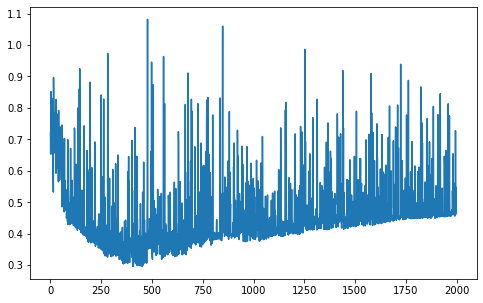

In [462]:
plt.figure(figsize=(8, 5))
plt.plot(error_list, label="Steady State at Node 1")

(4, 5)


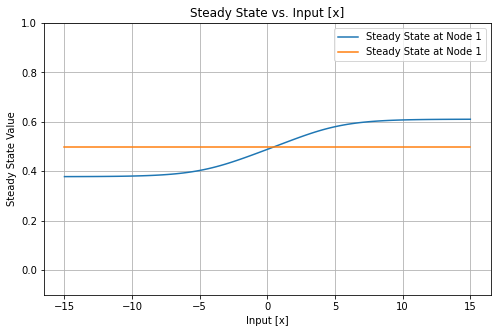

In [445]:
import matplotlib.pyplot as plt

# Define a range of input values
x_values = np.linspace(-15, 15, 100)  # Adjust range as needed
ss_values = []
ss_o_values = []

print(list(weight_matrix.g.edges())[input_inds[0][0]])

out_ind = 0
# Compute steady state for each input value
for x in x_values:
    ss = weight_matrix.compute_ss_on_inputs(input_inds, [x])
    output = compute_soft_maxed_output(ss, output_inds)
    ss_values.append(output[out_ind])
    ss_at_outputs = [ss[out] for out in output_inds]
    #ss_values.append(ss_at_outputs[out_ind])  # Assuming node index 1 is of interest

    ss = weight_matrix_orig.compute_ss_on_inputs(input_inds, [x])
    output = compute_soft_maxed_output(ss, output_inds)
    ss_o_values.append(output[out_ind])
    ss_at_outputs = [ss[out] for out in output_inds]
    #ss_o_values.append(ss_at_outputs[out_ind])  # Assuming node index 1 is of interest

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(x_values, ss_values, label="Steady State at Node 1")
plt.plot(x_values, ss_o_values, label="Steady State at Node 1")
plt.xlabel("Input [x]")
plt.ylabel("Steady State Value")
plt.title("Steady State vs. Input [x]")
plt.ylim(-0.1,1.)
plt.legend()
plt.grid()
plt.show()


In [194]:
import jax
import jax.numpy as jnp

def finite_difference_jacobian(A, zero_array, epsilon=1e-4):
    """Compute the Jacobian using finite differences."""
    A = jnp.array(A)  # Ensure it's a JAX array
    n_nodes_plus_1, n_nodes = A.shape  # Assuming A is (n_nodes, n_nodes+1)
    jacobian = jnp.zeros((n_nodes, n_nodes_plus_1, n_nodes))  # Desired shape

    for i in range(n_nodes_plus_1):
        for j in range(n_nodes):
            perturb = jnp.zeros_like(A)
            perturb = perturb.at[i, j].set(epsilon)

            f_plus = WeightMatrix.get_steady_state(A + perturb, zero_array)
            f_minus = WeightMatrix.get_steady_state(A - perturb, zero_array)

            jacobian = jacobian.at[:, i, j].set((f_plus - f_minus) / (2 * epsilon))  # Exclude appended 1.0

    return jacobian


A = weight_matrix.augmented_W_mat()
zero_array = weight_matrix.zero_array

# Compute JAX Jacobian
dW_mat_jax = jacobian_fn(A)

# Compute finite difference Jacobian
dW_mat_fd = finite_difference_jacobian(A, zero_array)

# Compute error
error = jnp.linalg.norm(dW_mat_jax - dW_mat_fd) / jnp.linalg.norm(dW_mat_fd)
print(f"Relative error: {error:.2e}")


Relative error: 1.47e-02


In [480]:
weight_matrix.W_mat

array([[nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan]])

In [193]:
dW_mat_jax

Array([[[ 0.0087826 ,  0.00666782,  0.00878258, ...,  0.00878258,
          0.00878258,  0.00878259],
        [-0.00097583, -0.00074086, -0.00097582, ..., -0.00097582,
         -0.00097583, -0.00097583],
        [-0.00097584, -0.00074087, -0.00097584, ..., -0.00097584,
         -0.00097584, -0.00097584],
        ...,
        [-0.00097585, -0.00074087, -0.00097585, ..., -0.00097585,
         -0.00097585, -0.00097585],
        [-0.00097584, -0.00074087, -0.00097584, ..., -0.00097584,
         -0.00097584, -0.00097584],
        [-0.00975802, -0.00740837, -0.009758  , ..., -0.009758  ,
         -0.00975801, -0.00975801]],

       [[-0.00097656, -0.00074141, -0.00097656, ..., -0.00097656,
         -0.00097656, -0.00097656],
        [ 0.00880213,  0.00668265,  0.00880212, ...,  0.00880212,
          0.00880212,  0.00880213],
        [-0.00097656, -0.00074141, -0.00097656, ..., -0.00097656,
         -0.00097656, -0.00097656],
        ...,
        [-0.00097657, -0.00074142, -0.00097656, ..., -